# Demo

以小鼠stereo-seq后整理的空间组学表达矩阵为例，利用stereopy工具对小鼠的空间组学进行数据分析。

数据矩阵格式如下, x,
y分别为基因在组织切片的空间位置，count为基因表达数量。

|  GeneID   | x | y | count |
|  ----  | ----  | ----| ----|
| Gene1  | 121 | 200 | 2 |
| Gene2  | 234 | 300 | 1 |

该矩阵作为初始输入，分析流程大概分为如下几步。

## read data

In [4]:
import stereo as st

In [5]:
mouse_data_path = './mouse/DP8400013846TR_F5.gem'
andata = st.io.reader.read_stereo_data(mouse_data_path, bin_size=100)
andata
# read_10x_mtx('/path/to/10x/matrix.mts')

2021-05-21 15:13:46 Spateo INFO: the martrix has 3347 bins, and 28553 genes.
2021-05-21 15:13:51 Spateo INFO: the size of matrix is 4.470348358154297e-08 G.


AnnData object with n_obs × n_vars = 3347 × 28553
    obsm: 'spatial'

为了方便处理，将矩阵信息取成andata的格式，andata将数据分成三个模块存储，其详细介绍在
*https://scanpy.readthedocs.io/en/latest/usage-principles.html#anndata*

由于stereo-seq是纳米级别的空间位置测序，每一个位置捕捉到的表达基因数目有限，
可以通过设置bin
size参数，将范围内的位点100\*100（bin\_size=100）合并成一个，适当的bin size能达到单细胞水平的分析效果。

支持读取10x的数据

## preprocess

预处理主要包括质控、过滤和标准化三个部分。

### quaity control

In [ ]:
andata = st.preprocess.cal_qc(andata=andata)

质控统计了三个指标，分别是

- the number of genes expressed in the count matrix(n_genes_by_counts), 每个bin表达的基因个数
- the total counts per cell(total_counts)，每个bin表达的基因总量
- the percentage of counts in mitochondrial genes(pct_counts_mt)，线粒体基因占比

小提琴图展示了质控这三个指标值的分布情况。

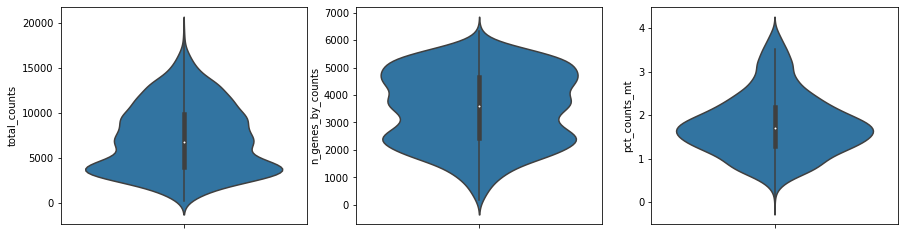

In [18]:
st.plots.plot_violin_distribution(andata)

### filter

统计后，可以根据这些指标指定的阈值对'细胞'进行过滤，选出高表达水平的'细胞'。

In [ ]:
st.preprocess.filter_cells(adata=andata, min_gene=200, n_genes_by_counts=3, pct_counts_mt=4, inplace=True)

### normalization

标准化的默认方法是归一化？，另外可选quantile标准化的方法。

In [12]:
normalizer = st.preprocess.Normalizer(data=andata, method='normalize_total', inplace=True, target_sum=10000)
nor_total = normalizer.fit()
# normalizer.method = 'quantile'
# nor_quantal = normalizer.fit()

预处理过后，可以通过空间分布散点图，展示小鼠的组织切片在空间范围的转录表达大体情况。

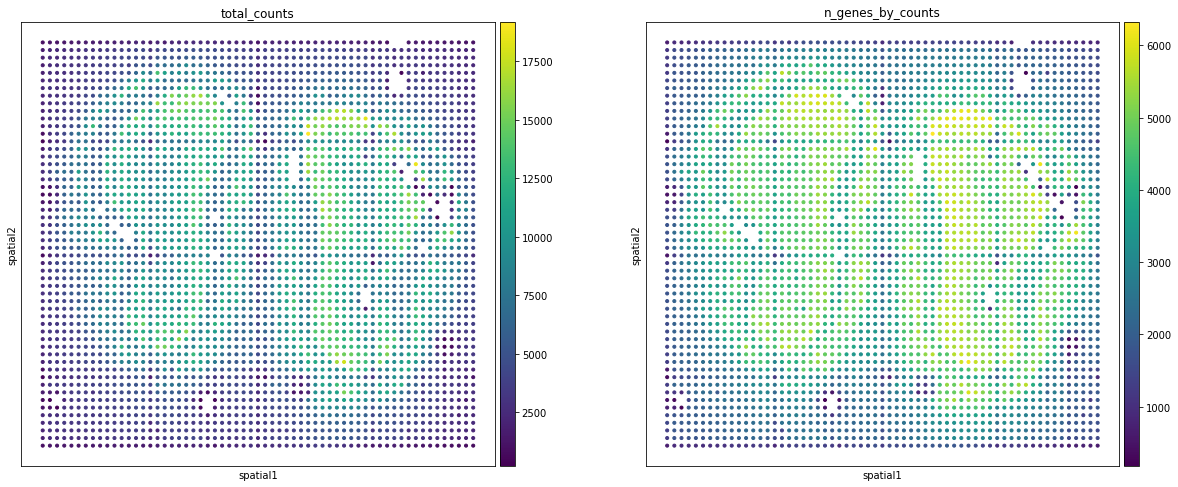

In [17]:
st.plots.plot_spatial_distribution(andata)

## dimensionality reduction

通过降维找出细胞的主成分特征，默认用PCA的方法降维，另外支持tsen、umap、factor analysis、low variance等降维方法

In [14]:
dim_reduce = st.tools.DimReduce(andata=andata, method='pca', n_pcs=30, min_variance=0.01, n_iter=250, n_neighbors=10, min_dist=0.3, inplace=False, name='dim_reduce')
dim_reduce.fit()
pca_x = dim_reduce.result.x_reduce

In [24]:
st.plots.plot_dim_reduce(andata, obs_key=['clustering'])

AttributeError: module 'stereo.plots' has no attribute 'plot_dim_reduce'

## cluster

对所有位点进行聚类后，再查看其空间分布情况，支持的聚类算法有leiden和louvain。

In [15]:
cluster = st.tools.Clustering(data=andata, method='leiden', outdir=None, dim_reduce_key='dim_reduce', n_neighbors=30, normalize_key='cluster_normalize', normalize_method=None, nor_target_sum=10000, name='clustering')
cluster.fit()

聚类过后查看各类细胞在组织的空间分布情况, obs_key参数为每次聚类对象的名称，对应Clustering类的name属性，空间分布图中每个颜色代表一类。

{'0': '#ee82ee', '1': '#40e0d0', '2': '#ff6347', '3': '#008080', '4': '#d2b48c', '5': '#c0c0c0', '6': '#a0522d', '7': '#ff0000', '8': '#800080', '9': '#dda0dd', '10': '#ffc0cb', '11': '#da70d6', '12': '#ff4500', '13': '#ffa500', '14': '#808000', '15': '#000080', '16': '#800000', '17': '#ff00ff', '18': '#00ff00', '19': '#90ee90', '20': '#add8e6', '21': '#e6e6fa', '22': '#f0e68c', '23': '#4b0082', '24': '#808080', '25': '#008000', '26': '#ffd700', '27': '#ff00ff', '28': '#006400', '29': '#00008b', '30': '#00ffff', '31': '#dc143c', '32': '#ff7f50', '33': '#d2691e', '34': '#7fff00', '35': '#a52a2a', '36': '#0000ff', '37': '#000000', '38': '#f5f5dc', '39': '#f0ffff', '40': '#7fffd4', '41': '#00ffff'}


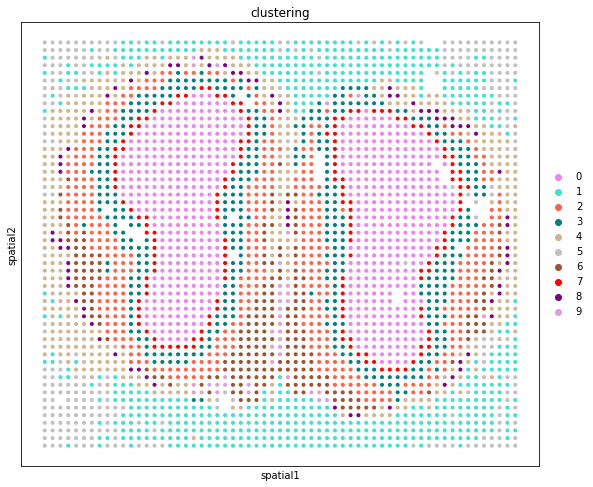

In [69]:
st.plots.plot_spatial_cluster(adata=andata, obs_key=['clustering'])

## find maker 

通过差异分析，找出聚类后每一组与其他组的差异基因。差异算法可选项为t-test和wilcoxon_test，cluster参数为Clustering类的name属性值。

In [16]:
marker = st.tools.FindMarker(data=andata, cluster='clustering', corr_method='bonferroni', method='t-test', name='marker_test')
marker.fit()

Find marker gene: 100%|██████████| 10/10 [00:20<00:00,  2.08s/it]


用差异基因热图，展示每一类细胞与其他类细胞score topN差异基因的分布，常用参数有：

- marker_uns_key: 对应聚类任务的名称，对应FindMarker类的name属性值
- cluster_method: 理解是聚类方法，但是用传leiden不正确，应该是Clustering类的name属性值
- num_show_gene:得分top n

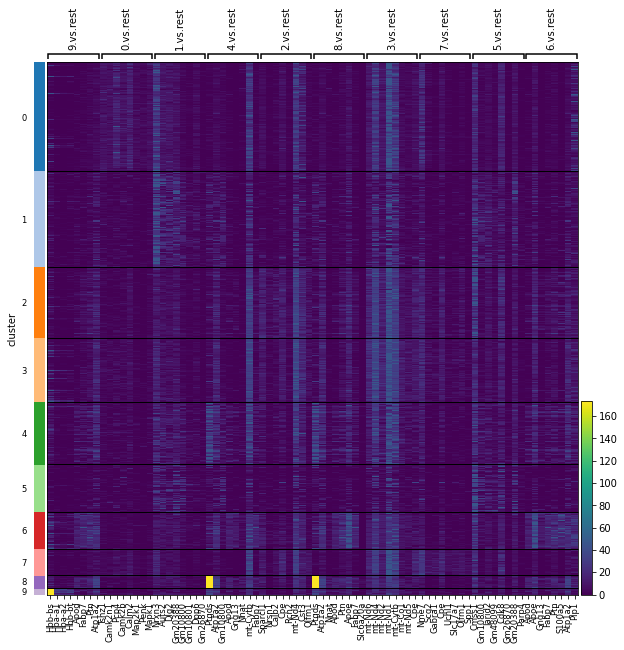

In [98]:
andata.uns['clustering']
# andata.uns['marker_test'].keys()
st.plt.plot_heatmap_maker_genes(andata, marker_uns_key='marker_test', cluster_method='clustering', num_show_gene=8)

下图同样展示各类差异基因的得分值情况， key为FindMarker类的name属性值。

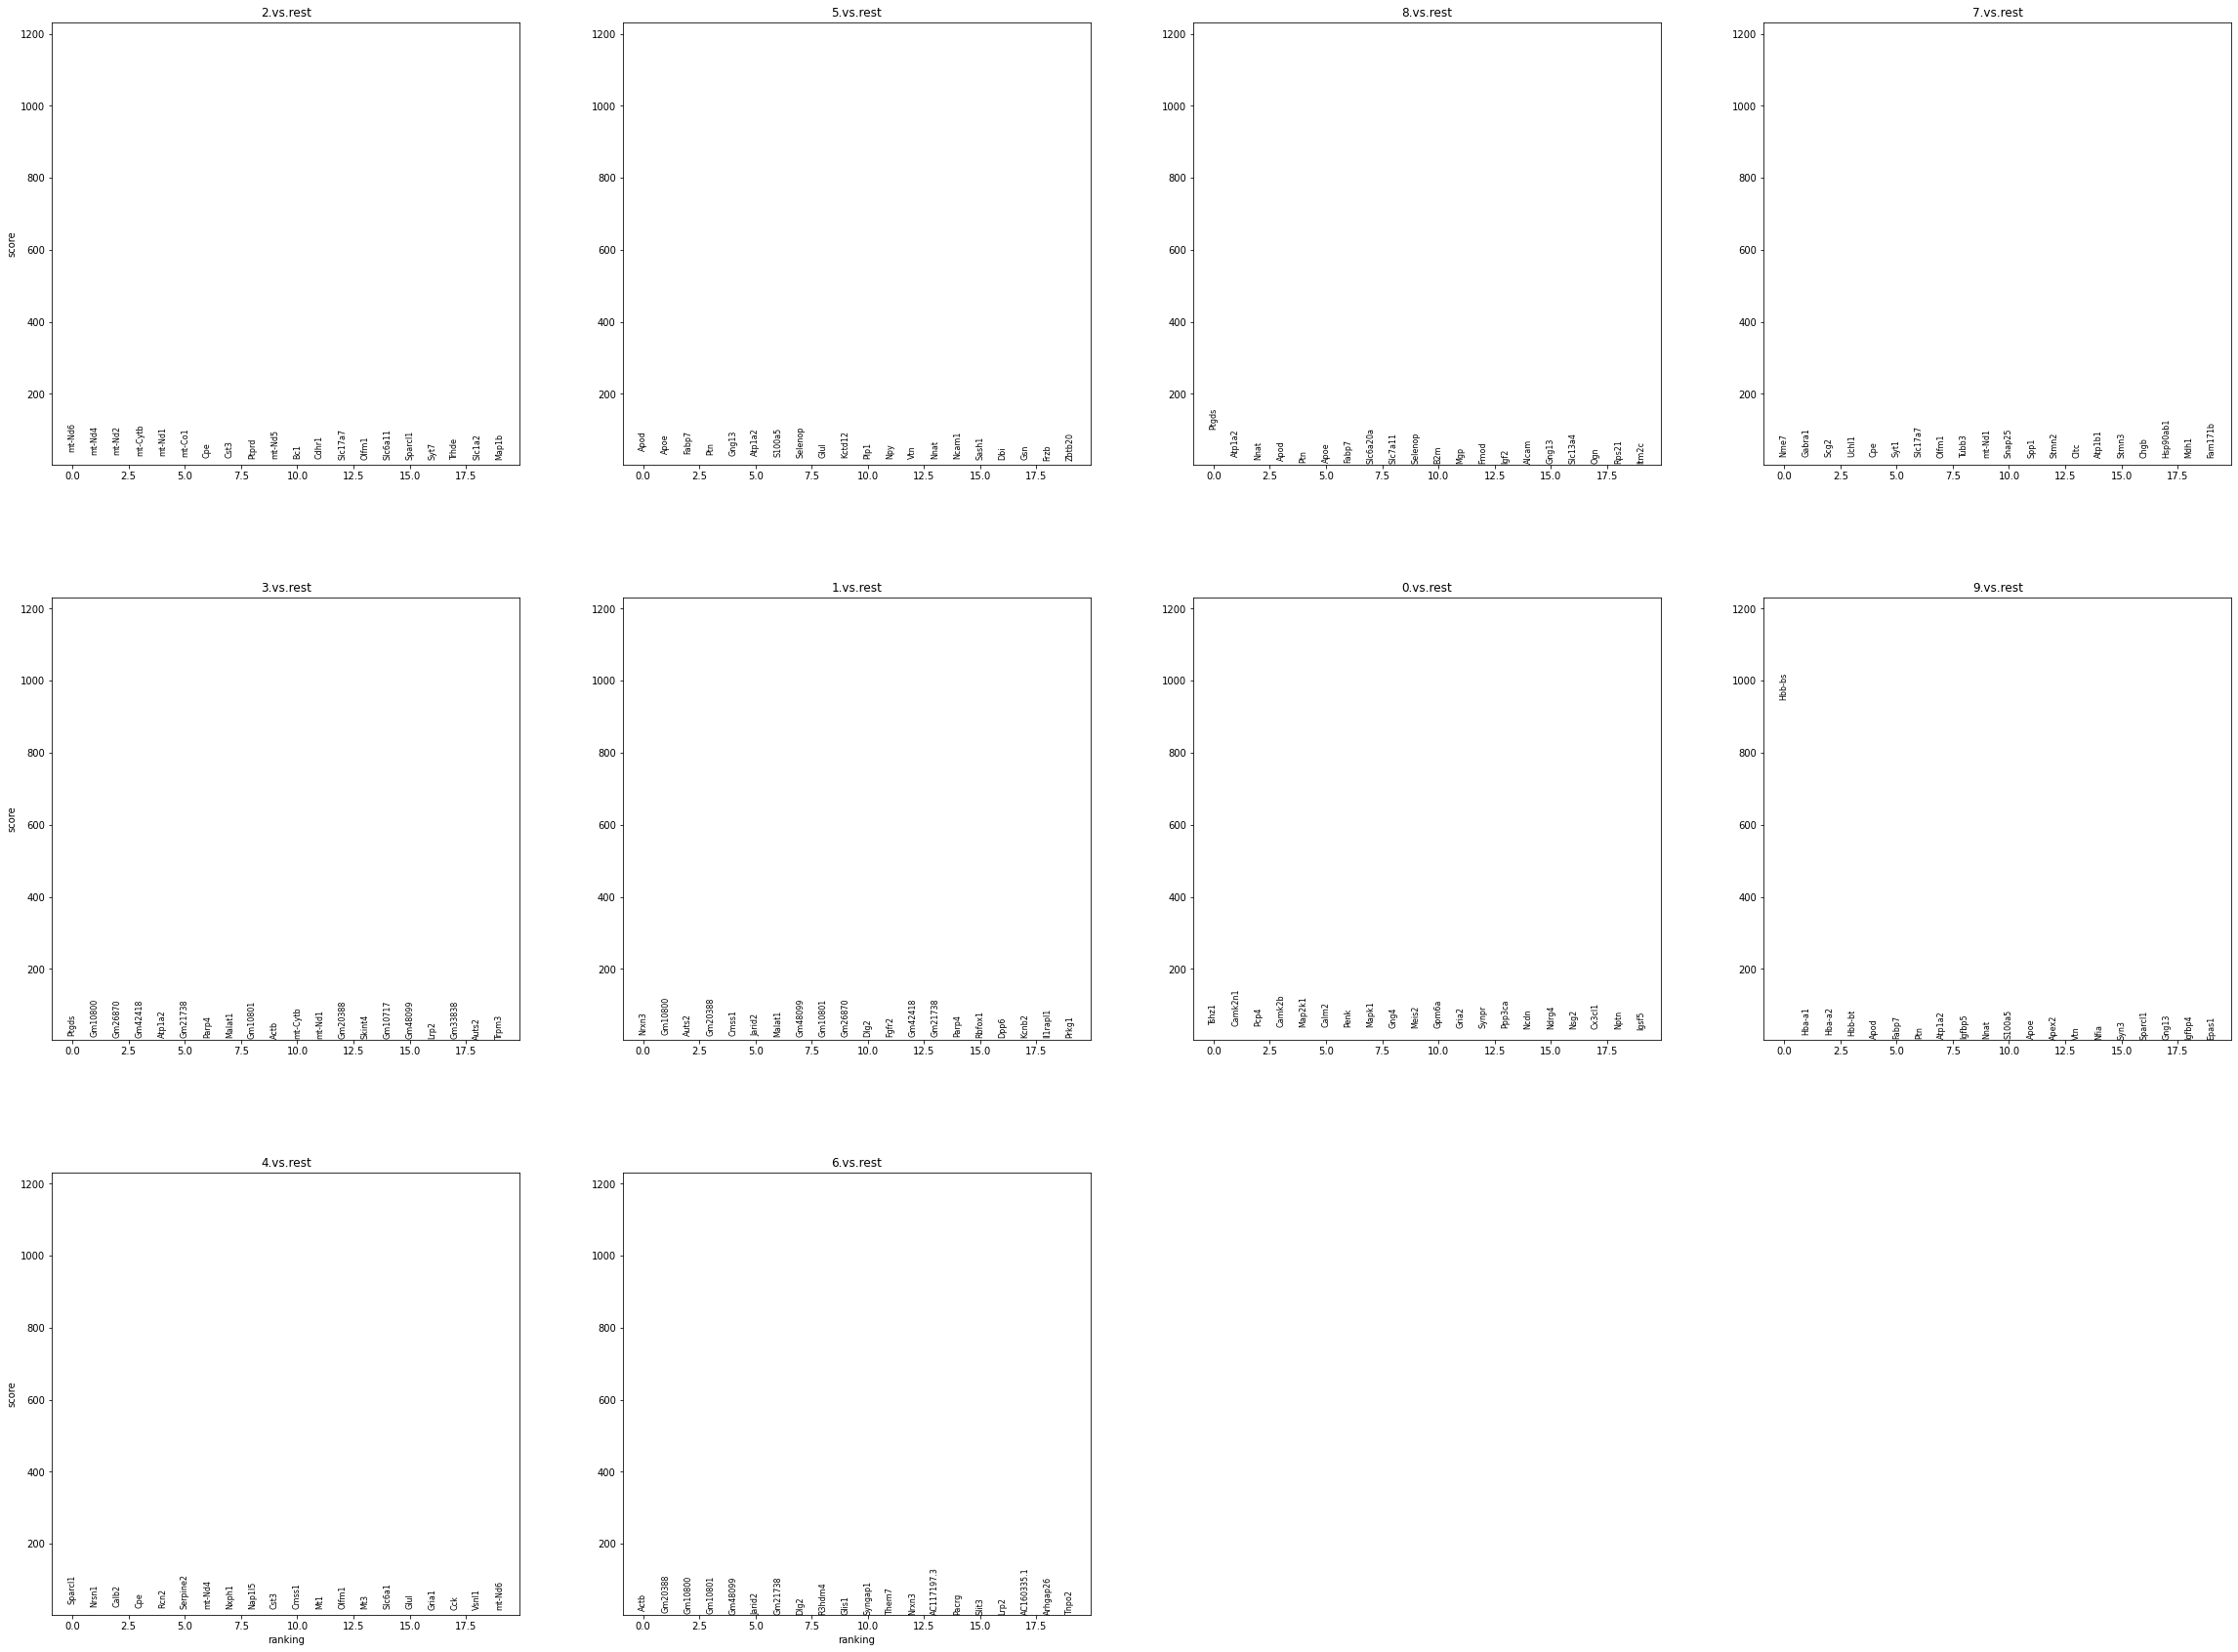

In [31]:
# andata.uns.keys()
st.plt.plot_degs(andata, key='marker_test')

##  annotation

如果bin size为细胞水平大小，可以通过此分析，能够注释出每个bin细胞所属细胞类型。

In [ ]:
cell_anno = st.tools.CellTypeAnno(adata=andata)
cell_anno.fit()

## GM model

通过空间灰度预测模型，预测计算细胞注释结果的置信区间和p value值

In [22]:
lag = st.tools.SpatialLag(data=andata, cluster='clustering')
lag.fit()
# dir(andata.uns['dim_reduce'])
# andata.uns['dim_reduce'].pcs
# andata.uns['dim_reduce'].variance_pca
# pd.DataFrame(andata.obs)

performing GM_lag_model and assign coefficient and p-val to cell type: 10311it [08:54, 12.71it/s]2021-05-24 10:17:26 Spateo ERROR: spatial lag get an error: Singular matrix.
performing GM_lag_model and assign coefficient and p-val to cell type: 17281it [16:54, 11.97it/s]2021-05-24 10:25:25 Spateo ERROR: spatial lag get an error: Singular matrix.
performing GM_lag_model and assign coefficient and p-val to cell type: 22155it [23:10, 11.15it/s]2021-05-24 10:31:41 Spateo ERROR: spatial lag get an error: Singular matrix.
performing GM_lag_model and assign coefficient and p-val to cell type: 28553it [32:15, 14.75it/s]
2021-05-24 10:40:47 Spateo WARNING: your AnnData.uns['spatial_lag'] is used by others, replacing it with a StereoResult.


SpatialLagResult of spatial_lag. 
  params: {'data': AnnData object with n_obs × n_vars = 3260 × 28553
    obs: 'total_counts', 'pct_counts_mt', 'n_genes_by_counts', 'clustering'
    uns: 'dim_reduce', 'clustering', 'marker_test', 'spatial_lag'
    obsm: 'spatial', 'method': 'gm_lag', 'name': 'spatial_lag', 'cluster': 'clustering', 'genes': None, 'random_drop': True, 'drop_dummy': None, 'n_neighbors': 8}
    result: a DataFrame which has `genes`,`lag_coeff`, `lag_zstat`, `lag_pval` columns.
    the shape is: (28553, 39)

## spatial pattern score

计算空间表达模式得分，通过基因的E10、C50和UMIcount计算模式得分？

In [29]:
sps = st.tools.SpatialPatternScore(data=andata)
sps.fit()

/data/workspace/st/stereopy-release/stereo/tools/spatial_pattern_score.py:72: RuntimeWarning: invalid value encountered in double_scalars
  e10 = np.around(100 * (np.sum(count_list[:int(len(count_list) * 0.1)]) / total_count), 2)


StopIteration: 

In [33]:
andata.write_csvs('./output/')

writing .csv files to output
